In [40]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

from utils import ELOModel
from sklearn.metrics import classification_report, confusion_matrix
from utils.data_visualizator import plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Elo Model
For this task, we will start of with a simple ELO-based model, before we add more and more features in order to capture the different nuances of football games.

## Background
In order to more accurately predict each game, we want to model the strength of each team participating in that game. The ELO rating system predicts the outcome of each game using that strength variable, and after its prediction, uses an update rule in order to update the strength rating of each team.

In [2]:
from utils import DataAggregator

In [3]:
data_aggregator = DataAggregator()
df = data_aggregator.get_data(wanted_leagues=["E0"],
                              wanted_features=["Date", "HomeTeam", "AwayTeam", "FTR", "B365H", "B365D", "B365A"])
df.head()

,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A
0,13/08/05,Aston Villa,Bolton,D,2.30,3.25,3.00
1,13/08/05,Everton,Man United,A,5.00,3.40,1.72
2,13/08/05,Fulham,Birmingham,D,2.37,3.25,2.87
3,13/08/05,Man City,West Brom,D,1.72,3.40,5.00
4,13/08/05,Middlesbrough,Liverpool,D,2.87,3.20,2.40


In [4]:
df = data_aggregator.format_date(df, date_column="Date")
df.head()

,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,Year,Month,Day,DayOfWeek
0,2002-08-17,Blackburn,Sunderland,D,1.727,3.25,4.333,2002,8,17,5
1,2002-08-17,Southampton,Middlesbrough,D,2.250,3.25,2.750,2002,8,17,5
2,2002-08-17,Man United,West Brom,H,1.200,5.00,12.000,2002,8,17,5
3,2002-08-17,Charlton,Chelsea,A,2.800,3.25,2.200,2002,8,17,5
4,2002-08-17,Fulham,Bolton,H,1.727,3.25,4.333,2002,8,17,5


The recency variable can be expressed by the following equation:

$Recency(t) = e^{0.01 * \frac{\Delta t}{365}}$

Where $\Delta t$ is the number of days since day t

In [5]:
df = data_aggregator.create_recency_variable(df, "Date")
df.head()

,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,Year,Month,Day,DayOfWeek,Recency
0,2002-08-17,Blackburn,Sunderland,D,1.727,3.25,4.333,2002,8,17,5,0.800959
1,2002-08-17,Southampton,Middlesbrough,D,2.250,3.25,2.750,2002,8,17,5,0.800959
2,2002-08-17,Man United,West Brom,H,1.200,5.00,12.000,2002,8,17,5,0.800959
3,2002-08-17,Charlton,Chelsea,A,2.800,3.25,2.200,2002,8,17,5,0.800959
4,2002-08-17,Fulham,Bolton,H,1.727,3.25,4.333,2002,8,17,5,0.800959


Since we want to "train" the model, and later test it, we will select all seasons from 2002/2003 - 2022/2023 as training data, while we test the model on the 2023/2024 season.

In [6]:
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

Now that we have gathered the neccessary data, lets move on to describing the elo-models we want to model.

# Elo models
First of all, lets discuss the shared factors between each model.

## Expected score

We first of all need to calculate the expected outcome of each team. This is done using the ``logistic commulative distribution function``. The expected result for the home team (in probabilities) will be:

$E_h = \sigma (\frac{r_h - r_a}{C * s}) = \frac{1}{1+e^{-\frac{r_h - r_a}{C * s}}}$ 

Where: 
- $r_h$ is the rating of the home team
- $r_a$ is the rating of the away team
- $C$ is the normalizaton constant
- $s$ is a sharpening factor

Since this is calculated as a probability, we can negate the above equation to get the expected result for the away team:

$E_a = 1 - E_h$

As we already know from above, the two expected outcomes add up to $1$, however, now we havent taken draws into account. We therefore need to add an expected draws value, and normalize the values:

$E_d = D*(1-|E_h-E_a|)$

Where
- $D$ is a draw constant

We then need to shift the values of $E_h$ and $E_a$:

- $E_h' = E_h - E_d/2$
- $E_a' = E_a - E_d/2$

We have parametarized $C$, $s$ and $D$ in order to perform a grid search in later stages in order to get a more precise model.

## Update rule


First of all, lets discuss how we process each match:
- If the home team wins, $S=1$
- If the away team wins, $S=0$
- If the game ends in a draw, $S=0.5$

Furthermore, we also need to discuss another parameter labeled as $\beta$. This is what we will denote as a recency parameter. I game that happened 15 years ago, should have less to say than a game that happened last week. This $\beta$-parameter is used to take this into account, by weighting recent matches more than former matches.

A third and last parameter to be discussed is $\alpha$. This can be compared to a ``learning rate``in a neural network, and describes how large of a change in the teams rating we want to happen for each match processed.

Now that we have discussed the different constant, lets discuss the update rule for a teams rating $R_i$:

For the home team:

$R_{new} = R_{old} + \alpha * (S-E_h) * \beta$

And for the away team:

$R_{new} = R_{old} + \alpha * ((1-S)-E_a) * \beta$



## Predicting the outcome
When we predict the outcome of the game, we use the gathered probabilities, $E_h$, $E_d$ and $E_a$ and pick a value of H, D or A with probability equal to the expected outcomes.

Now we are done explaining the different equations, lets move on to our implementations of the different models.

## Model 1
This will be the most basic model that we implement, we will use the following values:

- $R_{init} = 1500$
- $C = 400$
- $s = 1$ (sharpening factor)
- $\beta = 1$, i.e. we do not take recency into account.
- $\alpha = 40$ 
- $D = 0.2$


In [7]:
model_1 = ELOModel(
    initial_rating=1500,
    normalization_constand_cdf=400,
    sharpening_factor=1,
    alpha=40,
    home_advantage=0,
    momentum_boost=0,
    draw_factor=0.2,
    # seed=408 # For reproducibility
    seed=123
)

In [8]:
for index, row in df_train.iterrows():
    model_1.process_match(
        home_team=row["HomeTeam"], 
        away_team=row["AwayTeam"],
        full_time_result=row["FTR"],
        recency_parameter=1
        )

We can now have a look at how the elo rating changes for the current top 10 teams:

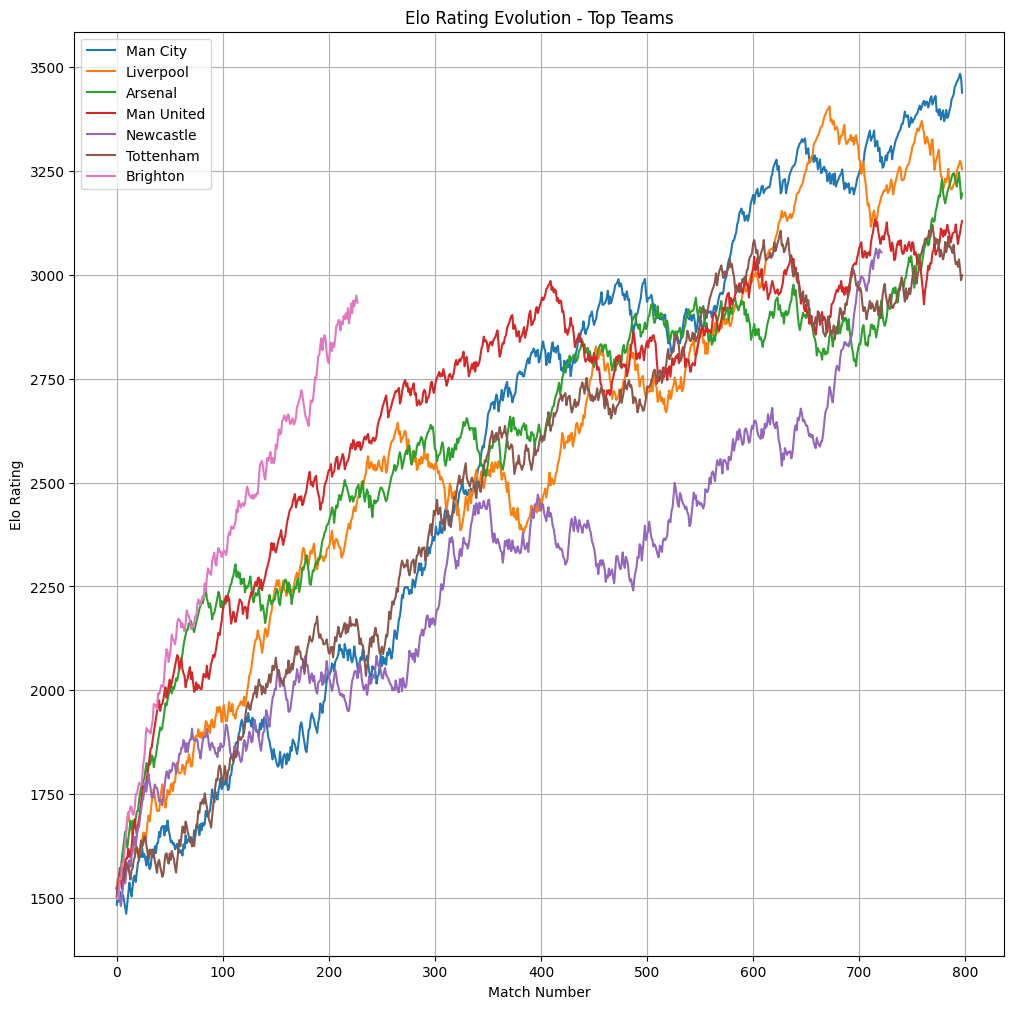

In [9]:
model_1.plot_ratings(top_k=7)

Lets test the model:

In [10]:
predictions = model_1.predict(df_test)

In [11]:
accuracy, won = data_aggregator.calculate_accuracy(predictions, "FTR", "Prediction")

In [12]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(predictions):.0f} out of {len(predictions)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 51.05%
The accuracy of the model is 194 out of 380 games.

With this model, the expected return on value would be -9.70€


In [13]:
data_aggregator.save_metrics("ELO-model-1", accuracy, won)

As we can see from the result above, we have already achieved results that is a lot better than the original baseline model. Lets now move on to create a more advanced model.

## Model 2
The equation for calculating the expected score will stay the same, however, we will change how we gather the value of a teams that should be passed to the expected score. The original function for the expected score:

$E_h = \sigma (\frac{r_h - r_a}{C * s}) = \frac{1}{1+e^{-\frac{r_h - r_a}{C * s}}}$ 

We will now change how we gather the values $r_h$ and $r_a$. Instead of it just being the teams current rating, it will now be:

- $r_h' = r_h + \tau + m_h$
- $r_a' = r_a + m_a$

We see from the equation above that we have introduced some new variables, what do they mean?

- $\tau$ can be considered the home advantage, i.e. since home teams wins more games than away teams, this is something that should be modeled.
- $m_h$ and $m_a$ are the momentum factor for the home and away team respectively. The intuition behind this factor is that teams that currently are on a winning streak will often perform better than their current level.

Lets see how we can calculate the momentum factors:

$m_i = b * |streak_i|$

In other words, for every team, $i$, they will get an increase in their "current match rating" (not overall elo rating) of a constant b, momentum boost, multiplied by how many games in a row they have won.

Finally, we will also use the recency parameter that we have created.

For this model, we will use the following values:

- $R_{init} = 1500$
- $C = 400$
- $s = 1$ (sharpening factor)
- $\beta$ - varying
- $\alpha = 40$ 
- $D = 0.2$
- $\tau = 40$ - home advantage
- $b = 10$ - momentum boost

In [14]:
model_2 = ELOModel(
    initial_rating=1500,
    normalization_constand_cdf=400,
    sharpening_factor=1,
    alpha=40,
    home_advantage=40,
    momentum_boost=10,
    draw_factor=0.2,
    # seed=408 # For reproducibility
    seed=123
)

In [15]:
for index, row in df_train.iterrows():
    model_2.process_match(
        home_team=row["HomeTeam"], 
        away_team=row["AwayTeam"],
        full_time_result=row["FTR"],
        recency_parameter=row["Recency"]
        )

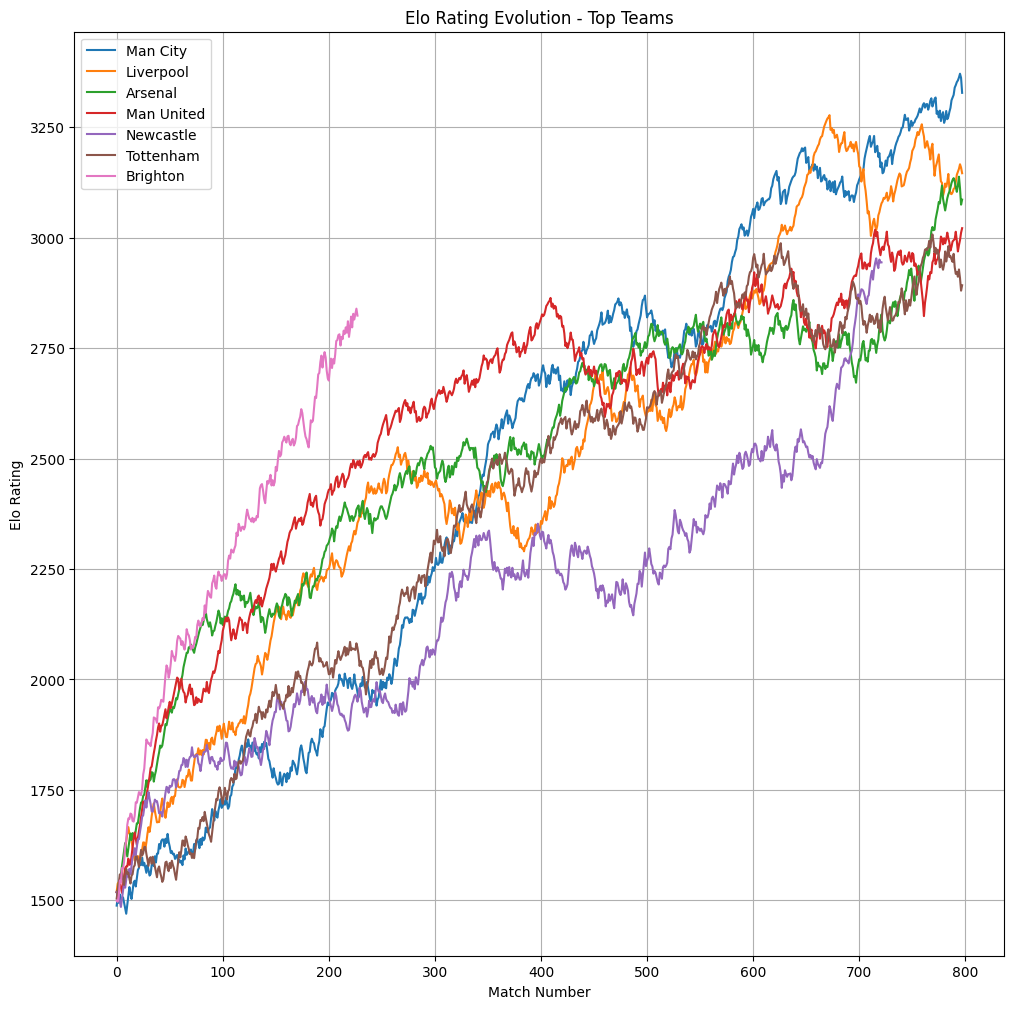

In [16]:
model_2.plot_ratings(top_k=7)

In [17]:
predictions = model_2.predict(df_test)

In [18]:
accuracy, won = data_aggregator.calculate_accuracy(predictions, "FTR", "Prediction")

In [19]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(predictions):.0f} out of {len(predictions)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 51.58%
The accuracy of the model is 196 out of 380 games.

With this model, the expected return on value would be 89.90€


In [20]:
data_aggregator.save_metrics("ELO-model-2", accuracy, won)

Before we move on to some feature engineering and classifiers, lets see how good we can get this model by performing a grid search.

## Optimized model

In [21]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initial_rating': [1300, 1500, 1700],
    'alpha': [30, 40, 50],
    'normalization_constand_cdf': [200, 400, 600],
    'sharpening_factor': [0.5, 1.0, 1.5],
    'home_advantage': [0, 50, 100],
    'momentum_boost': [0, 5, 10, 15, 20],
    'draw_factor': [0.0, 0.1, 0.2]
}

In [22]:
USE_GRID_SEARCH = False

if USE_GRID_SEARCH:
    best_accuracy = 0
    best_params = None

    for params in tqdm(ParameterGrid(param_grid)):
        model = ELOModel(**params)
        for index, row in df_train.iterrows():
            model.process_match(
                home_team=row["HomeTeam"], 
                away_team=row["AwayTeam"],
                full_time_result=row["FTR"],
                recency_parameter=row["Recency"]
                )
            
        predictions = model.predict(df_test)
        accuracy, _ = data_aggregator.calculate_accuracy(predictions, "FTR", "Prediction")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

In [23]:
if USE_GRID_SEARCH:
    print(f"The best accuracy is {best_accuracy:.2%}")
    print(f"The best parameters are {best_params}")

In [24]:
if not USE_GRID_SEARCH: # Results from the grid search
    best_params = {
        'initial_rating': 1300,
        'normalization_constand_cdf': 200,
        'sharpening_factor': 0.5,
        'alpha': 30,
        'home_advantage': 50,
        'momentum_boost': 0,
        'draw_factor': 0.1,
        # 'seed': 408
        'seed': 123
    }

Now lets initialize the model with the best parameters, and see how good our model is

In [25]:
optimized_model = ELOModel(**best_params)

In [26]:
for index, row in df_train.iterrows():
    optimized_model.process_match(
        home_team=row["HomeTeam"], 
        away_team=row["AwayTeam"],
        full_time_result=row["FTR"],
        recency_parameter=row["Recency"]
        )

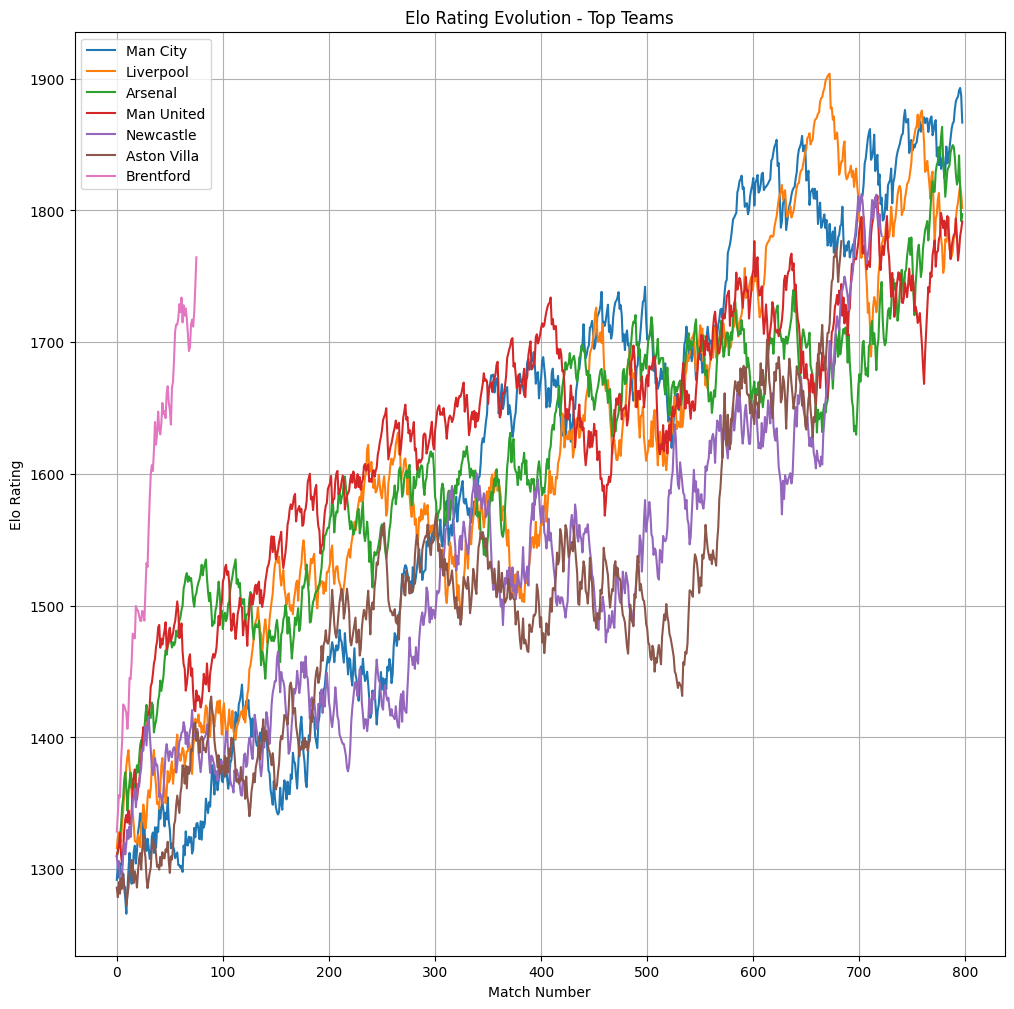

In [27]:
optimized_model.plot_ratings(top_k=7)

In [28]:
predictions = optimized_model.predict(df_test)

In [29]:
accuracy, won = data_aggregator.calculate_accuracy(predictions, "FTR", "Prediction")

In [30]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(predictions):.0f} out of {len(predictions)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 54.21%
The accuracy of the model is 206 out of 380 games.

With this model, the expected return on value would be 283.60€


In [35]:
print("Classification report:")
print(classification_report(predictions["FTR"], predictions["Prediction"]))

Classification report:
              precision    recall  f1-score   support

           A       0.48      0.55      0.51       123
           D       0.32      0.09      0.13        82
           H       0.61      0.75      0.67       175

    accuracy                           0.54       380
   macro avg       0.47      0.46      0.44       380
weighted avg       0.50      0.54      0.50       380



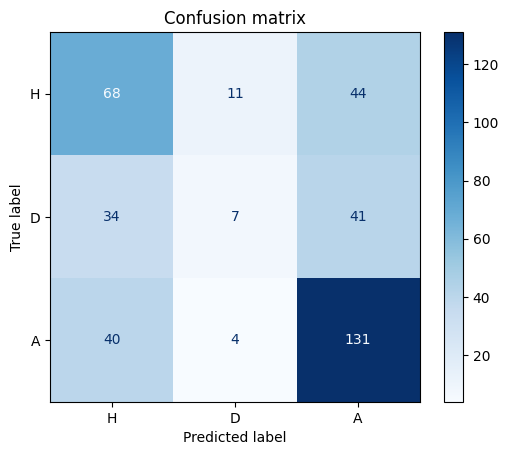

In [41]:
cm = confusion_matrix(predictions["FTR"], predictions["Prediction"])
plot_confusion_matrix(cm, ["H", "D", "A"])

In [ ]:
data_aggregator.save_metrics("optimized-ELO-model", accuracy, won)